In [1]:
# import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import model from model.h5
from keras.models import load_model, Model
model = load_model('model.h5')

In [2]:
test_df = pd.read_csv("./dataset/split-data/test_new.csv")
testgen = ImageDataGenerator(rescale=1./255)
test_generator = testgen.flow_from_dataframe(
    dataframe=test_df,
    directory="./dataset/img",
    x_col="img_path",
    y_col="category",
    target_size=(256, 256),
    batch_size=128,
    class_mode="categorical",
    workers=4
)

Found 5311 validated image filenames belonging to 46 classes.


In [53]:
# remove the last layer
model = Model(inputs=model.input, outputs=model.layers[-2].output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy, top_k_categorical_accuracy'])

# save all the features for the test data
features = model.predict(test_generator)


C:\Users\Paolo Canigiula\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step


In [87]:
# test using the first element of test_generator
import random

feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Initialize arrays for storing features, inputs, and labels
features = []
inputs = []
labels = []


total_batches = len(test_generator)
print(total_batches)
# random_batch_indices = random.sample(range(total_batches), 300)
print(len(test_generator))

batch_index = 0

for batch_x, batch_y in test_generator:
    batch_index += 1

    if batch_index % 100 != 0:
        continue
    print("Processing batch:", batch_index)
    # Stop when we've processed all batches
    print("one loop")
    batch_features = feature_extractor.predict(batch_x)
    
    # Append features, inputs, and labels
    features.append(batch_features)
    inputs.append(batch_x)
    labels.append(batch_y)
    
    # Stop when len(features) reaches 10
    if len(features) >= 20:
        break

image_paths = test_df["img_path"].values

# Convert lists to NumPy arrays
features = np.concatenate(features, axis=0)
inputs = np.concatenate(inputs, axis=0)
labels = np.concatenate(labels, axis=0)

# Save features, inputs, and labels to a file
data_to_save = {
    'features': features,
    'inputs': inputs,
    'labels': labels,
    'paths': image_paths
}
np.save('clothing_features_with_paths.npy', data_to_save)
np.set_printoptions(threshold=1000) 
print("Features shape:", features.shape)
print("First feature vector:", features[0])



42
42
Processing batch: 100
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Processing batch: 200
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 300
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 400
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 500
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 600
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 700
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 800
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 900
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1000
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1100
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1200
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1300
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1400
one loop
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Processing batch: 1500
one loop
4/4 ━━━━━━━━━━━━━━━

In [56]:
!pip install faiss-cpu

In [89]:
import numpy as np

features = features.astype('float32')

np.save('faiss_features.npy', features)
np.save('faiss_inputs.npy', inputs)
np.save('faiss_labels.npy', labels)

print("Features and metadata saved for Faiss.")


Features and metadata saved for Faiss.


In [90]:
# Example: If the feature vector dimensionality is known (e.g., 1024)
d = 1024
n_samples = features.size // d

# Reshape the 1D array into 2D
features = features.reshape(n_samples, d)
print("Reshaped features:", features.shape)

print("Features shape:", features.shape)
print("Features data:", features)  # Print some data to confirm
print("Original features list length:", len(features))
print("Shape of first batch in features list:", features[0].shape)  # Shape of individual batch


Reshaped features: (2560, 1024)
Features shape: (2560, 1024)
Features data: [[2.7318177e-04 2.8221575e-03 3.4177499e-03 ... 4.0899223e-01
  1.0806193e-01 3.9951257e-02]
 [3.3650553e-04 2.0981582e-03 4.0627001e-03 ... 5.1185685e-01
  3.8123727e-01 1.5739201e+00]
 [4.6560192e-04 2.5889694e-03 3.5830713e-03 ... 2.0446371e-01
  9.5986590e-02 7.8996688e-01]
 ...
 [1.0457179e-03 6.5894662e-03 3.5285905e-03 ... 7.7195722e-01
  5.9546407e-02 4.0226749e-01]
 [4.4863397e-04 2.5384929e-03 3.7199587e-03 ... 1.0727725e+00
  5.1611327e-02 1.3235162e-01]
 [3.1412876e-04 3.8423212e-03 3.2877945e-03 ... 6.7753577e-01
  1.9157639e-02 5.0995022e-01]]
Original features list length: 2560
Shape of first batch in features list: (1024,)


In [91]:
import faiss

# Load saved features
saved_data = np.load('clothing_features_with_paths.npy', allow_pickle=True).item()
features = saved_data['features']
image_paths = saved_data['paths']

# Get dimensionality of features
d = features.shape[1]  # Feature vector dimension

# Create Faiss index (using L2 distance for exact search)
index = faiss.IndexFlatL2(d)
index.add(features)  # Add feature vectors to the index

print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 2560


In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from matplotlib import pyplot as plt


# Load and preprocess the new input image
new_input_path = "./dataset/img_for_rec/IMG_5606.jpeg"    # Replace with your image path
img = load_img(new_input_path, target_size=(256, 256))  # Resize to match `target_size`
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, H, W, C)

# Create an ImageDataGenerator for preprocessing
inputgen = ImageDataGenerator(rescale=1./255)

# Preprocess the new input
new_input_generator = inputgen.flow(img_array, batch_size=1)



C:\Users\Paolo Canigiula\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Extracted feature vector: [[0.00039874 0.00414509 0.00655918 ... 0.37406015 0.00655346 0.00411823]]
Distances: [[135.65353 135.65353 135.65353 162.41425 211.28827]]
Indices: [[ 591 1061 2273 1267 2050]]
['img/Southwestern_Print_Batwing_Cardigan/img_00000043.jpg', 'img/Self-Tie_Wrap_Culottes/img_00000031.jpg', 'img/Acid_Wash_Jeggings/img_00000047.jpg', 'img/Cloud_Wash_Distressed_Cutoffs/img_00000010.jpg', 'img/Ripped_Skinny_Jeans/img_00000025.jpg']


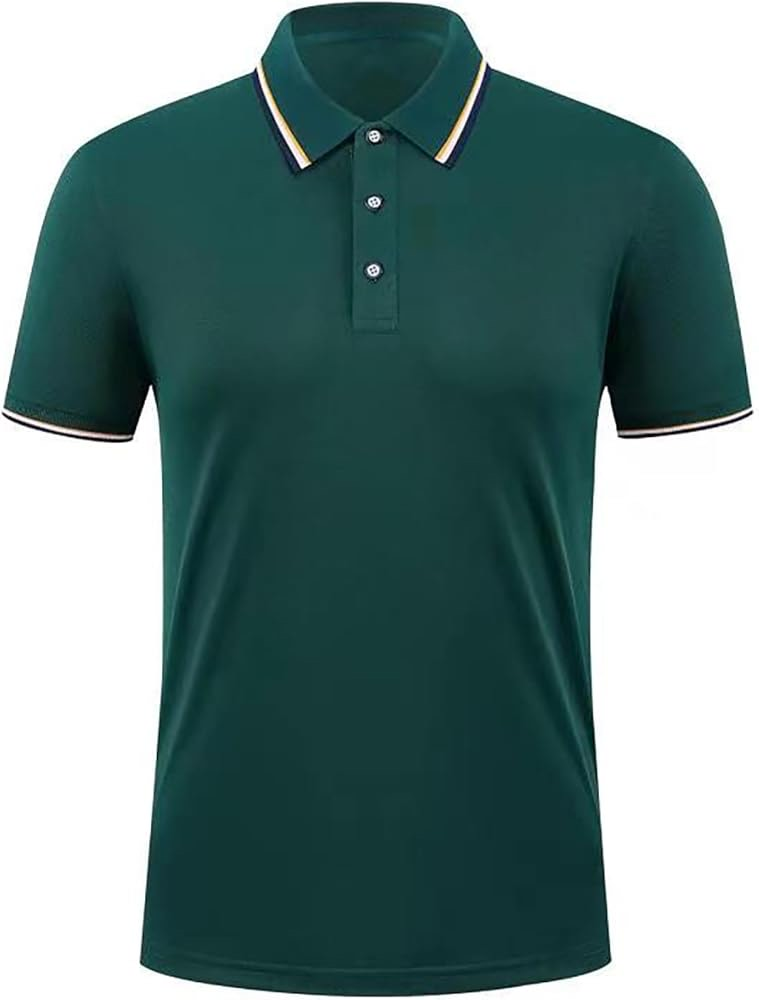

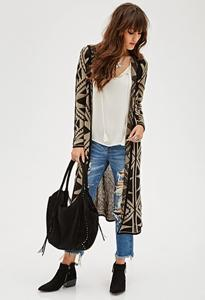

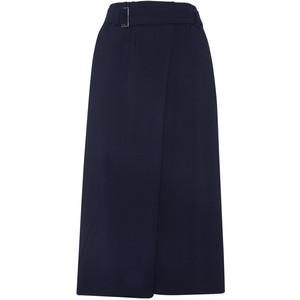

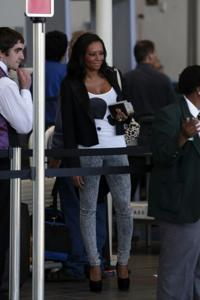

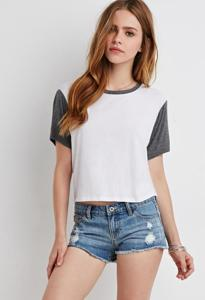

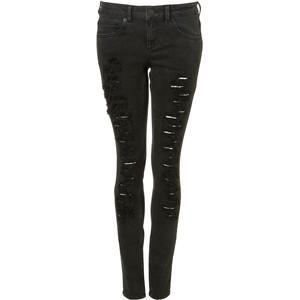

In [97]:
from IPython.display import display, Image

feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
new_input_features = feature_extractor.predict(new_input_generator)

print("Extracted feature vector:", new_input_features)
k = 5  # Number of neighbors to retrieve
distances, indices = index.search(new_input_features, k)

print("Distances:", distances)
print("Indices:", indices)

similar_image_paths = [image_paths[idx] for idx in indices[0]]
original_path = "./dataset/img_for_rec/IMG_5606.jpeg"
print(similar_image_paths)

# Display the original and similar images
def display_images(original_path, similar_image_paths):
    display(Image(filename = original_path))
    
    for path in similar_image_paths:
        display(Image(filename="./dataset/img/" + path))

display_images(original_path, similar_image_paths)